**Universidade Federal do Rio Grande do Sul**  
Departamento de Engenharia Civil (DECIV)  
ENG01007 - Análise Estrutural por Computador  
*prof. Felipe Schaedler de Almeida*

---

In [1]:
#Importando os módulos do Python necessários para esse notebook.
from math import * #módulo com funções matemáticas
import numpy as np #módulo para operar com arrays
import AEC_ex02 as aec #módulo com funções necessárias para este notebook
import procedimentos as pmm #procedimentos básicos dos métodos matriciais
import matplotlib.pyplot as plt #módulo para criação de gráficos
import time #módulo com funções relacionados ao tempo

%matplotlib inline

# Exemplo: Análise de uma treliça plana pelo MRD

Resolução dos exercícios 3.4 e 3.5 do livro *Matrix Structural Analysis 2ed* 

<img src="AEC_ex02_modelo.png" alt="Estrutura do exemplo 3.4 e 3.5" style="width:400px">

Dados do problema (forças em kN e comprimentos em mm):

In [2]:
B_exemplo = 5.0e3 #mm
ang_exemplo = radians(60.0)

x_a = 0.0
z_a = 0.0
x_b = B_exemplo
z_b = 0.0
x_c = B_exemplo
z_c = B_exemplo*tan(ang_exemplo)
x_d = 2*B_exemplo
z_d = z_c

A_ab_cd_exemplo = 10.e3 #mm²
A_ac_bc_bd_exemplo = 15.e3 #mm²
E_exemplo = 200 #kN/mm²

F_d_ang = radians(-45.0)
F_d_intensidade = 400 #kN


### Dados gerais da análise de treliças planas (T2D)

In [3]:
num_gdl_no = 2 #número de gdl por nó 
num_nos_el = 2 #número de nós por elemento
dim_espaco = 2 #número de dimensões do espaço no problema (2D)
num_gdl_el = num_nos_el * num_gdl_no #número de gdl por elemento


## Dados do problema (em arrays):
Dados de entrada em arrays para aplicação no *procedimento geral* do método da rigidez direta

<img src="AEC_ex02_modelo+discreto.png" alt="Numeração dos nós e elementos na estrutura do exemplo 3.4 e 3.5" style="width:700px">

In [4]:
#materiais:
mat1 = aec.Material(E_exemplo,0.0,nome='Matrial do exemplo 02')

#seções transversais (adotando I2=I3=J=1 em todas):
sec = list()
sec.append(aec.Secao(mat1, A_ab_cd_exemplo,1,1,1,nome='seção das barras ab e cd'))#barras ab e cd
sec.append(aec.Secao(mat1, A_ac_bc_bd_exemplo,1,1,1,nome='seção das barras ac,  bc e bd')) #barras ac, bc, bd

#Nós: Coordenadas e apoios-----------------
num_nos = 4 #número de nós da estrutura
#Nós - coordenadas:
coor_no = np.zeros((num_nos,dim_espaco)) #inicia a array das coordenadas com zeros
coor_no[0,:] = [x_a,z_a]
coor_no[1,:] = [x_b,z_b]
coor_no[2,:] = [x_c,z_c]
coor_no[3,:] = [x_d,z_d]

#Elementos:
num_els = 5 #Número de elementos da estrutura
#Elementos - conectiviades:
con_el = np.zeros((num_els,num_nos_el),dtype=int) #inicia uma array de inteiros para guardar as conectividades dos elementos
con_el[0,:] = [0,1]
con_el[1,:] = [2,3]
con_el[2,:] = [0,2]
con_el[3,:] = [1,2]
con_el[4,:] = [1,3]

#Elementos - seções:
sec_el = num_els*[None] #incia uma lista com elementos vazios para guardar as seções dos elementos
sec_el[0] = sec_el[1] = sec[0]
sec_el[2] = sec_el[3] = sec_el[4] = sec[1]

#condições de contorno e carregamento:

#Nós - apoios:
gdlr_no = num_nos*[[]] #inicia uma lista com elementos vazios para armazenar os gdlr dos nós
gdlr_no[0] = [0,1]
gdlr_no[1] = [1]

#Nós - forças:
p_no = np.zeros((num_nos,num_gdl_no)) #inicia a array das forças nodais com zeros
p_no[3,:] = [ F_d_intensidade * cos(F_d_ang) , F_d_intensidade * sin(F_d_ang) ]


## Procedimento geral do Método da Rigidez Direta para análise de treliça

### 1) Cálculos preliminares

#### 1.1) Cálculo do número total de gdl do problema;

In [5]:
#Número total de gdl da estrutura
num_gdl_global = num_nos * num_gdl_no

#### 1.2) Definição dos gdl de cada nó:

- Os gdl são numerados segundo a ordem crescente da numeração dos nós.
- As translações na $u_{xi}$ e $u_{zi}$ são o primeiro e segundo, respectivametne, gdl de cada nó $i$.
- Os gdl são agrupados em gdl livres (superíndice $F$) e de apoio (superíndice $S$), de forma que o vetor de deslocamentos pode ser escrito como: $$ \boldsymbol{d} = \begin{Bmatrix} \boldsymbol{d}^{F} \\ \boldsymbol{d}^{S} \end{Bmatrix}$$

e o sistema glboal de equações fica:  
  
    
$$ \begin{bmatrix} \boldsymbol{K}^{FF} & \boldsymbol{K}^{FS} \\ \boldsymbol{K}^{SF} & \boldsymbol{K}^{SS} \end{bmatrix} \begin{Bmatrix} \boldsymbol{d}^{F} \\ \boldsymbol{d}^{S} \end{Bmatrix} = \begin{Bmatrix} \boldsymbol{p}^{F} \\ \boldsymbol{p}^{S} \end{Bmatrix}$$


<img src="AEC_ex02_discreto+gdl.png" alt="Numeração dos gdl na estrutura do exemplo 3.4 e 3.5" style="width:900px">

In [6]:
#atribuição dos gdl dos nós    
igdl_no, (num_gdl_F, num_gdl_S) = pmm.igdl_FS(num_gdl_no,gdlr_no)

In [7]:
#Impressão dos gdl dos nós==================================================================================
print(' Número total de gdls:', num_gdl_global)
print(' Número total de gdls livres:', num_gdl_F)
print(' Número total de gdls restritos:', num_gdl_S)
print('\n Índice global dos gdl de cada nó:')
for ino in range(num_nos):
    print(f' no{ino} :{igdl_no[ino]}')

 Número total de gdls: 8
 Número total de gdls livres: 5
 Número total de gdls restritos: 3

 Índice global dos gdl de cada nó:
 no0 :[5 6]
 no1 :[0 7]
 no2 :[1 2]
 no3 :[3 4]


### 2) Formação do sistema global de equações:

#### 2.1) Cálculo da matriz de rigidez dos elementos ($\boldsymbol{K}_e$) e montagem da matriz de rigidez global da estrutura ($\boldsymbol{K}$):
- Cada termo $K_{ij}$ da matriz de rigidez global $\boldsymbol{K}$ relaciona a força externa $p_i$ na direção do gdl global $i$ ao deslocamento generalizado ($d_j$) na direção do gdl $j$.
- Os termos são obtidos pela contribuição de cada elemento ($e$) que se conecta aos gdl $i$ e $j$:
  $K_{ij} = \sum_e K_{ij}^{(e)}$ 



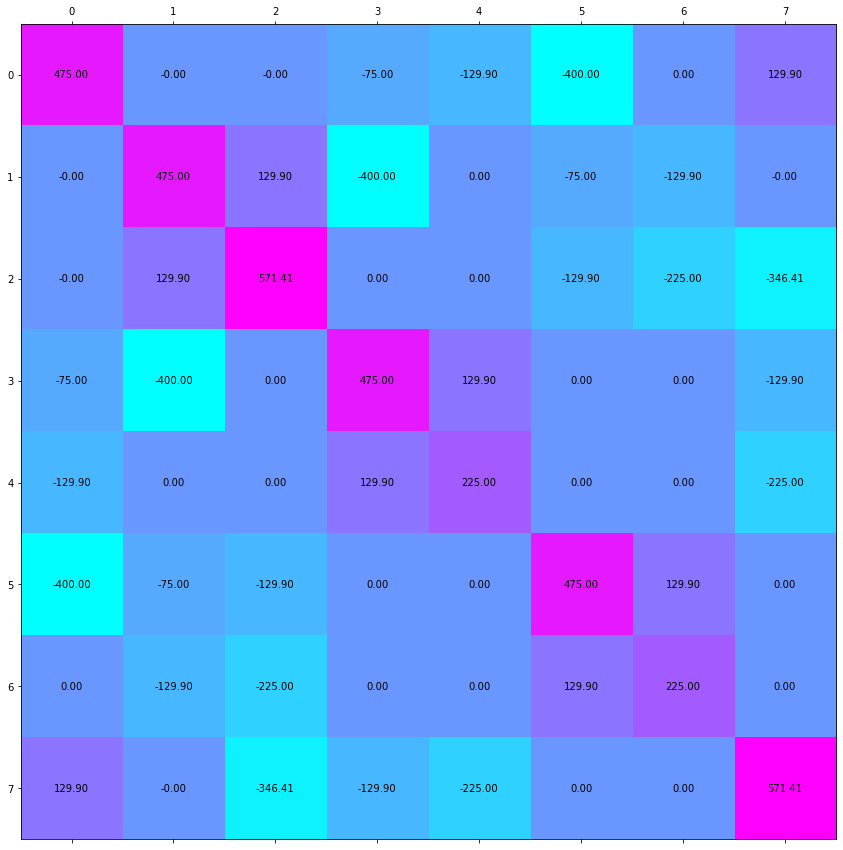

In [13]:
#inciando a matriz de rigidez global com zeros
K_global = np.zeros( (num_gdl_global, num_gdl_global) )

##figura para visualização da matriz de rigidez global do modelo
fig_K_global, ax_K_global = plt.subplots(figsize=(15,15))
from IPython import display

for iel in range(num_els):
    
    #índice dos nós do elemento
    noI, noJ = con_el[iel]
    
    #coordenadas dos nós do elemento
    rI, rJ = coor_no[ [noI, noJ] ]
    #rI = coor_no[noI]
    #rJ = coor_no[noJ]
    
    #comprimento e ângulo do elemento
    l_el , phi_el = aec.T2D_L_phi(rI, rJ)
    
    #cálculo da matriz de rigidez dos elementos (no sistema global)
    K_el = aec.T2D_K_global_phi(sec_el[iel], l_el, phi_el)
    
    #índice global dos gdl do elemento
    igdl_el = list(igdl_no[noI]) + list(igdl_no[noJ])

    #adicionar os coeficientes de rigidez do elemento à matriz global do modelo
    pmm.espalhar(K_el, K_global, igdl_el)
    
    #motra a figura com o mapa de cores para os elementos da matriz de rigidez global
    ax_K_global.cla()
    #ax_K_global.matshow(K_global, cmap=plt.cm.Blues)
    ax_K_global.matshow(K_global, cmap=plt.cm.cool)
    for i_linha in range(num_gdl_global):
        for j_coluna in range(num_gdl_global):
            coef_ij = "%.2f" % K_global[i_linha,j_coluna]
            ax_K_global.text(i_linha, j_coluna, coef_ij, va='center', ha='center')
        
    print(f'iel= 0-{iel}')
    display.display(plt.gcf())
    time.sleep(2.0)
    display.clear_output(wait=True)
    

In [ ]:
#Impressão da matriz de rigidez global =============================================================
with np.printoptions(precision=3,linewidth=100,suppress=True):
     print('\n K global: \n',K_global)

#### 2.2) Formação do vetor de forças externas nodais ($\boldsymbol{p}$)

In [ ]:
P_global = np.zeros(num_gdl_global)
for p, ig in zip(p_no,igdl_no):
    P_global[ ig ] += p[:]

In [ ]:
#Impressão do vetor de forças externas
with np.printoptions(precision=3,linewidth=100):
    print('\n P global: \n',P_global)

### 3) Cálculo dos deslocamentos nodais pela solução do sistema global de equações

Os deslocamentos livres $\boldsymbol{d}^{F}$ são calculados resolvendo o sistema de equações reduzido 
$$ \boldsymbol{K}^{FF} \boldsymbol{d}^{F} = \boldsymbol{p}^{F}$$

In [ ]:
d = np.zeros(num_gdl_global) #vetor de deslocamentos nodias (total)

d_F = d[:num_gdl_F] #deslocamentos livres (aponta para o trecho de d)
P_F = P_global[:num_gdl_F] #forças nodais nos gdl livres
K_FF = K_global[:num_gdl_F,:num_gdl_F] #coeficientes de rigides associando os gdl livres

#solução do sistema de equações
d_F[:] =  np.linalg.solve(K_FF,P_F)

#obs: d_F[:] deve ser usado para apontar para as posições dos gdl livres no vetor d (que armazena os resultados)

In [ ]:
print(d)

In [ ]:
#Impressão dos deslocamentos de cada nó
with np.printoptions(precision=3,linewidth=100):
    print('\n Deslocamentos nodais: ')
    for no in range(num_nos):
        print('no=',no,', d=',d[igdl_no[no,:]])


### 4) Cálculo das quantidades de interesse com base nos deslocamentos nodais:

#### 4.1) Cálculo das reações de apoio nos gdl impedidos:  
- As reações de apoio são obtidas por: $$ R = \boldsymbol{K}^{SF} \boldsymbol{d}^{F}- \boldsymbol{p}^{S}$$

In [ ]:
K_SF = K_global[-num_gdl_S:,:-num_gdl_S]
P_S = P_global[-num_gdl_S:]
Reacoes = K_SF @ d_F - P_S

In [ ]:
#Impressão das reações
nome_reacao = ['fx','fz']
print('\n Reações: ')    
for ino, il in enumerate(gdlr_no):
    if len(il) == 0: continue
    ig = igdl_no[ino,il]
    print(f'no{ino} :',*[ f'{nome_reacao[il[j]]} = {Reacoes[ig[j]-num_gdl_F]} ,' for j in range(len(il)) ] )      

#### 4.2) Cálculo das forças nas barras:
- em cada elemento (e), a força axial pode ser obtida por:

$ N = \dfrac{EA}{L} \left( u_{1j} - u_{1i} \right)$

- os deslocamento $u_1$ pode ser obtido pela projeção do vetor de transação $\boldsymbol{u}=\{ u_x, u_z\} ^T$ no eixo da barra pelo produto escalar:

$u_1 = \boldsymbol{u} \cdot \boldsymbol{e}_1$

onde  $\boldsymbol{e}_1 = \boldsymbol{r}_{IJ}/L$  é o  vetor unitário que dá a direção e do elemento.


<img src="T2D_u1.png" alt="Força na barra de treliça" style="width:350px">

In [ ]:
N = np.zeros(num_els)

for iel in range(num_els):
    #índice dos nós do elemento
    noI, noJ = con_el[iel]
    
    #coordenadas dos nós do elemento
    rI, rJ = coor_no[ [noI, noJ]]
    
    #comprimento e vetor unitário na direção do noI para o noJ
    l_el , e_1 = pmm.calc_L_u(rI, rJ)
    
    #deslocamentos dos nós segundo as coordenadas globais
    u_I = d[igdl_no[noI]]
    u_J = d[igdl_no[noJ]]
    
    # dos nós na direção do eixo local 1
    u_1I = e_1 @ u_I
    u_1J = e_1 @ u_J
    
    #força normal no elemento
    N[iel] = sec_el[iel].EA * (u_1J - u_1I) / l_el
             

In [ ]:
#Impressão das forças nas barras
print('\n Forças nas barras:')        
for iel in range(num_els):
    print(f'el={iel} : N = ',N[iel])